### Here we answer some realted questions by exploring the data set in details

In [40]:
import pandas as pd
import numpy as np
import glob, os, sys
osp = sys.platform
import matplotlib.pyplot as plt
%matplotlib inline
from utilities import LoadData
from helpers import id_player, id_position, id_teams, get_player_trajectory, segment
%load_ext autoreload
%autoreload 2
# ---------------------------------------------------------
# directories
main_dir = '../'
game_dir = main_dir+'data/'
Data = LoadData(main_dir, game_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### How many games there are?

In [2]:
!find ../data/ -type f -name '*.pkl' | wc -l

42


In [3]:
file_names = glob.glob(game_dir+'*.pkl')
!ls ../data/

0021500009.pkl	0021500131.pkl	0021500272.pkl	0021500390.pkl	0021500529.pkl
0021500024.pkl	0021500150.pkl	0021500278.pkl	0021500408.pkl	0021500540.pkl
0021500042.pkl	0021500164.pkl	0021500290.pkl	0021500421.pkl	0021500554.pkl
0021500057.pkl	0021500173.pkl	0021500308.pkl	0021500441.pkl	0021500621.pkl
0021500066.pkl	0021500188.pkl	0021500323.pkl	0021500463.pkl	0021500633.pkl
0021500075.pkl	0021500196.pkl	0021500337.pkl	0021500477.pkl	0021500649.pkl
0021500096.pkl	0021500219.pkl	0021500355.pkl	0021500492.pkl	game0021500463
0021500109.pkl	0021500239.pkl	0021500357.pkl	0021500507.pkl
0021500115.pkl	0021500250.pkl	0021500383.pkl	0021500511.pkl


#### Meta info: 
42 games in Fall 2015 Raptors, cameras oprate at 25 frames per second and cover the whole court throughout the game

#### Would player get different roles or even id for some games?

In [4]:
%%time
game_ids = [i.split('/')[-1].split('.')[0] for i in file_names]
all_events = [pd.DataFrame(Data.load_game(f)['events']) for f in game_ids]

CPU times: user 7min 49s, sys: 5.18 s, total: 7min 54s
Wall time: 7min 50s


In [5]:
%%time
id_players = [id_player(i) for i in all_events]
id_positions = [id_position(i) for i in all_events]

CPU times: user 5.92 s, sys: 0 ns, total: 5.92 s
Wall time: 5.93 s


In [6]:
# all mappings id - players
all_id_players = {}
n1 = 0
for i in id_players:
    for key, value in i.items():
        if key not in all_id_players.keys():
            all_id_players[key] = value
        else:
            if all_id_players[key] != value:
                print(key, value)
                n1+=1
                all_id_players[key] += ' | ' + value
print('Total {0:} games out of which {1:} has conflict.\n'.format(len(id_players), n1))

# all mappings id - positions            
all_id_positions = {}
n2 = 0
for i in id_positions:
    for key, value in i.items():
        if key not in all_id_positions.keys():
            all_id_positions[key] = value
        else:
            for v in value:
                if v not in all_id_positions[key]:
                    print(key, all_id_players[int(key)], value, all_id_positions[key])
                    n2 += 1
                    all_id_positions[key].append(v)
print('Total {0:} game out of which {1:} has conflict (same player got assigned different roles).'.format(len(id_positions), n2))

Total 42 games out of which 0 has conflict.

202687 Bismack Biyombo ['C-F'] ['F']
203114 Khris Middleton ['G-F'] ['F']
203948 Johnny O'Bryant ['F-C'] ['C']
201162 Jared Dudley ['G-F'] ['F']
202083 Wesley Matthews ['G'] ['G-F']
101139 CJ Miles ['G-F'] ['F-G']
203096 Jared Sullinger ['C-F'] ['F']
Total 42 game out of which 7 has conflict (same player got assigned different roles).


In [32]:
aip_df = pd.DataFrame.from_dict(all_id_players, orient='index')
aip_df.reset_index(inplace=True)
# aip_df.rename()

In [36]:
aip_df = aip_df.rename(columns={'index': 'player_id', 0: 'player_name'})
aip_df.to_csv('./meta_data/id_player.csv', index=False)

In [38]:
aip_df = pd.DataFrame.from_dict(all_id_positions, orient='index')
aip_df.reset_index(inplace=True)

In [39]:
aip_df = aip_df.rename(columns={'index': 'player_id', 0: 'player_positions'})
aip_df.to_csv('./meta_data/id_positions.csv', index=False)

#### All unique roles

In [7]:
roles = list(set([j for i in list(all_id_positions.values()) for j in i]))
roles

['F-C', 'G-F', 'F', 'G', 'C', 'C-F', 'F-G']

#### The max and min moments length

In [16]:
max_moment = -1
min_moment = 1e5
moment_lens = []
for i in all_events:
    mi = i['moments'].apply(lambda x: len(x)).values
    moment_lens+= list(mi)
    max_i, min_i = mi.max(), mi.min()
    if max_i > max_moment:
        max_moment = max_i
    if min_i < min_moment:
        min_moment = min_i
print('max: {0:} | min: {1:}'.format(max_moment, min_moment))

max: 11370 | min: 2


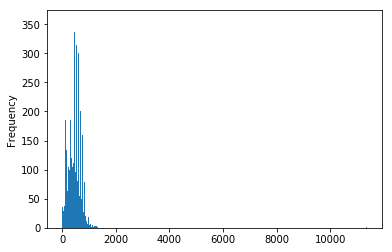

In [22]:
pd.Series(np.array(moment_lens)).plot(kind='hist', bins=1000)

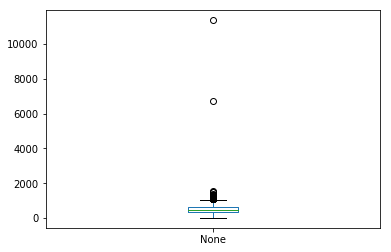

In [24]:
pd.Series(np.array(moment_lens)).plot(kind='box')#, bins=1000)

In [43]:
id_teams(all_events)

{1610612737: 'Atlanta Hawks',
 1610612738: 'Boston Celtics',
 1610612739: 'Cleveland Cavaliers',
 1610612740: 'New Orleans Pelicans',
 1610612741: 'Chicago Bulls',
 1610612742: 'Dallas Mavericks',
 1610612743: 'Denver Nuggets',
 1610612744: 'Golden State Warriors',
 1610612746: 'Los Angeles Clippers',
 1610612747: 'Los Angeles Lakers',
 1610612748: 'Miami Heat',
 1610612749: 'Milwaukee Bucks',
 1610612751: 'Brooklyn Nets',
 1610612752: 'New York Knicks',
 1610612753: 'Orlando Magic',
 1610612754: 'Indiana Pacers',
 1610612755: 'Philadelphia 76ers',
 1610612756: 'Phoenix Suns',
 1610612758: 'Sacramento Kings',
 1610612759: 'San Antonio Spurs',
 1610612760: 'Oklahoma City Thunder',
 1610612761: 'Toronto Raptors',
 1610612762: 'Utah Jazz',
 1610612764: 'Washington Wizards',
 1610612766: 'Charlotte Hornets'}

In [44]:
aip_df = pd.DataFrame.from_dict(id_teams(all_events), orient='index')
aip_df.reset_index(inplace=True)
aip_df = aip_df.rename(columns={'index': 'team_id', 0: 'team_name'})
aip_df.to_csv('./meta_data/id_team.csv', index=False)

In [ ]:
del all_events

In [ ]:
# first try to predict next trajectories for single player
pid = 2200
pid_track = pd.DataFrame(event_df['moments'].apply(lambda m: get_player_trajectory(m, pid)))
pid_track = pid_track[pid_track.moments.apply(lambda m: len(m) != 0)]
pid_track.reset_index(inplace=True, drop=True)
pid_track['length'] = pid_track.moments.apply(lambda m: len(m))

In [ ]:
pid_track.head()

In [ ]:
pid_track.length.sum()/2

In [ ]:
train = []
for i in range(len(pid_track)):
    train += segment(pid_track.moments[i], length=2)

train = np.array(train)

In [ ]:
n, m, f = train.shape
train.shape

In [ ]:
# create label
label = train[:, :, :2].reshape(n*m, 2)
cut = n*m
print(cut)
if label.shape[0] %2 == 0:
    cut -= 1
print(cut, label.shape)
label = label[1:cut, :].reshape((cut-1)//2, 2, 2)
# also remove the last one in train
train = train[:-1, :, :]
train.shape

In [ ]:
# train = train.reshape(-1, 5)
train.shape

In [ ]:
label.shape

In [ ]:
# only take the prediction of second timestep
label = label[:, 1, :]

In [ ]:
label.shape

In [ ]:
pid_track.length.min()

In [ ]:
train.shape

In [ ]:
batch_size = 117
timesteps = 2
input_dim = 5

model = Sequential()
# model.add(LSTM(512 ,return_sequences=True, batch_input_shape=(batch_size, timesteps, input_dim), stateful=True))
# model.add(LSTM(512 , return_sequences=False, stateful=True))
model.add(LSTM(512 ,return_sequences=True, input_shape=(timesteps, input_dim)))
model.add(LSTM(512 , return_sequences=False))
model.add(Dense (2))
model.add(Activation('linear'))
model.summary()

In [ ]:
model.compile(loss='mse', optimizer='adagrad')
#model.compile(loss='mse', optimizer=adagradOpt)
# model.load_weights(model_name)
#model.load_weights('init_weights_minibatch1024_10epochs.h5') # Load the pretrained model
# model.reset_states()

In [ ]:
history = model.fit(train, label, epochs = 20, batch_size = batch_size, 
                    verbose = 2, shuffle = True, validation_split = 0.2)

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.grid('on')
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "valid"], loc = "upper right")
plt.show()